## Set up Environment

In [1]:
import wandb
wandb.init('19010c4e439d59bec411f7f9075c6e73ac7f5e13')    # Initialize wandb with your API key
wandb.login() 

wandb: Currently logged in as: yadav-sunil531984 (hsp_bits). Use `wandb login --relogin` to force relogin


wandb: WARNING Calling wandb.login() after wandb.init() has no effect.


True

In [2]:
import os
os.environ['WANDB_NOTEBOOK_NAME'] = 'HSP_Multi_Class_Classifier_Using_BERT_Fine_Tuned_Model_on_data_3.0_HF-Copy1.ipynb'
os.environ['CUDA_VISIBLE_DEVICES'] = '0'

In [3]:
!nvidia-smi

Fri May 24 16:26:24 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.171.04             Driver Version: 535.171.04   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  NVIDIA A100 80GB PCIe          Off | 00000000:21:00.0 Off |                    0 |
| N/A   62C    P0             263W / 300W |  61388MiB / 81920MiB |     99%      Default |
|                                         |                      |             Disabled |
+-----------------------------------------+----------------------+--

## Import the Labraries

In [4]:
import pandas as pd
import torch
from transformers import AutoTokenizer
from datasets import load_dataset
from transformers import DataCollatorWithPadding
from transformers import AutoModelForSequenceClassification 
import evaluate
import numpy as np
from transformers import Trainer
from transformers import TrainingArguments
from peft import get_peft_model, LoraConfig, TaskType
from transformers import AutoModelForSequenceClassification, AutoTokenizer
import matplotlib.pyplot as plt

2024-05-24 16:26:31.258796: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-05-24 16:26:32.036721: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


## Load Data sets

Total Count of Samples =  4374


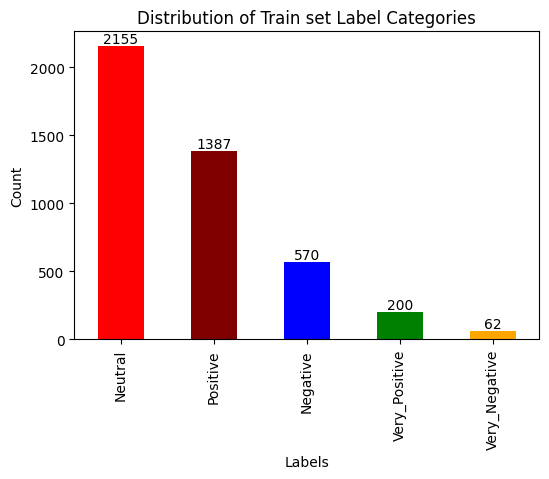

In [5]:
# Visualization of Class Labels Taining data
train_df=pd.read_csv('HSP_Train_Data_with_Encoded_Label_Multi_3.0.csv')

print("Total Count of Samples = ", len(train_df))
label_counts = train_df['Label'].value_counts()

# Updated colors list to include 6 colors for 6 classes
colors = ['red', 'maroon', 'blue', 'green', 'orange', 'purple']

plt.figure(figsize=(6, 4))
ax = label_counts.plot(kind='bar', color=colors)
for p in ax.patches:
    ax.annotate(str(p.get_height()), (p.get_x() + p.get_width() / 2., p.get_height()),
                ha='center', va='center', xytext=(0, 5), textcoords='offset points')

plt.title('Distribution of Train set Label Categories')
plt.xlabel('Labels')
plt.ylabel('Count')
plt.show()

Total Count of Samples =  938


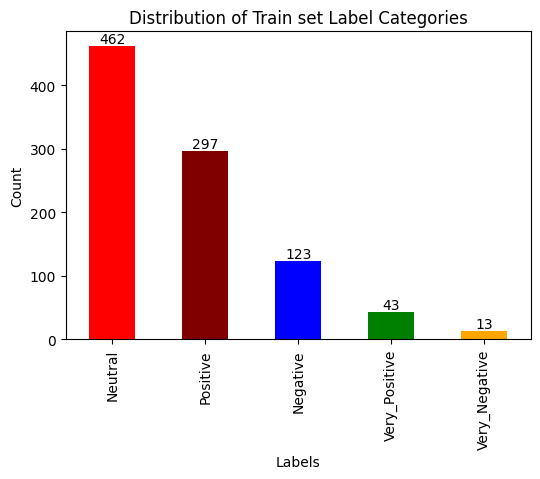

In [6]:
# Visualization of Class Labels Validation data
val_df=pd.read_csv('HSP_Val_Data_with_Encoded_Label_Multi_3.0.csv')

print("Total Count of Samples = ", len(val_df))
label_counts = val_df['Label'].value_counts()

# Updated colors list to include 6 colors for 6 classes
colors = ['red', 'maroon', 'blue', 'green', 'orange', 'purple']

plt.figure(figsize=(6, 4))
ax = label_counts.plot(kind='bar', color=colors)
for p in ax.patches:
    ax.annotate(str(p.get_height()), (p.get_x() + p.get_width() / 2., p.get_height()),
                ha='center', va='center', xytext=(0, 5), textcoords='offset points')

plt.title('Distribution of Train set Label Categories')
plt.xlabel('Labels')
plt.ylabel('Count')
plt.show()

Total Count of Samples =  938


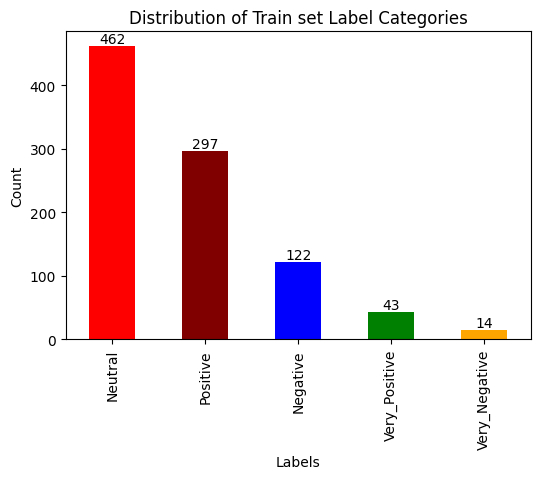

In [7]:
# Visualization of Class Labels Taining data
test_df=pd.read_csv('HSP_Test_Data_with_Encoded_Label_Multi_3.0.csv')

print("Total Count of Samples = ", len(test_df))
label_counts = test_df['Label'].value_counts()

# Updated colors list to include 6 colors for 6 classes
colors = ['red', 'maroon', 'blue', 'green', 'orange', 'purple']

plt.figure(figsize=(6, 4))
ax = label_counts.plot(kind='bar', color=colors)
for p in ax.patches:
    ax.annotate(str(p.get_height()), (p.get_x() + p.get_width() / 2., p.get_height()),
                ha='center', va='center', xytext=(0, 5), textcoords='offset points')

plt.title('Distribution of Train set Label Categories')
plt.xlabel('Labels')
plt.ylabel('Count')
plt.show()

In [8]:
train_df=pd.read_csv('HSP_Train_Data_with_Encoded_Label_Multi_3.0.csv')
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4374 entries, 0 to 4373
Data columns (total 5 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   id         4374 non-null   int64 
 1   Text       4374 non-null   object
 2   Label_Id   4374 non-null   int64 
 3   Label      4374 non-null   object
 4   Label_Rev  4374 non-null   int64 
dtypes: int64(3), object(2)
memory usage: 171.0+ KB


In [9]:
unique_values = train_df['Label_Rev'].unique()
unique_values 

array([0, 2, 1, 3, 4])

## Number of Characters

In [10]:
# Number of Characters
import pandas as pd

# Load the training data from the CSV file
train_df = pd.read_csv('HSP_Train_Data_with_Encoded_Label_Multi_3.0.csv')

# Calculate the maximum number of characters in the 'text' column
max_char = train_df['Text'].str.len().max()

# Calculate the maximum number of words in the 'text' column
max_words = train_df['Text'].str.split().str.len().max()

print(f"Maximum number of characters: {max_char}")
print(f"Maximum number of words: {max_words}")


Maximum number of characters: 1116
Maximum number of words: 97


## Preprocess Data for Training

In [11]:
MAX_LEN = 512 
bert_checkpoint = "bert-base-uncased"

In [12]:
# Load the tokenizer:
bert_tokenizer = AutoTokenizer.from_pretrained(bert_checkpoint, add_prefix_space=True)

In [13]:
from datasets import load_dataset
from transformers import DataCollatorWithPadding

# Assuming mistral_tokenizer and MAX_LEN are defined earlier
def bert_preprocessing_function(examples):
    return bert_tokenizer(examples['Text'], truncation=True, max_length=MAX_LEN)

# Load each dataset file
train_dataset = load_dataset('csv', data_files='HSP_Train_Data_with_Encoded_Label_Multi_3.0.csv')['train']
val_dataset = load_dataset('csv', data_files='HSP_Val_Data_with_Encoded_Label_Multi_3.0.csv')['train']  # Assuming dev_data is for validation
test_dataset = load_dataset('csv', data_files='HSP_Test_Data_with_Encoded_Label_Multi_3.0.csv')['train']

# Define the columns to be removed
col_to_delete = ['id', 'Text', 'Label_Id', 'Label']

# Apply preprocessing to each dataset separately
bert_tokenized_train_dataset = train_dataset.map(bert_preprocessing_function, batched=True, remove_columns=col_to_delete)
bert_tokenized_val_dataset = val_dataset.map(bert_preprocessing_function, batched=True, remove_columns=col_to_delete)
bert_tokenized_test_dataset = test_dataset.map(bert_preprocessing_function, batched=True, remove_columns=col_to_delete)

# Rename the 'target' column to 'label' in each dataset
bert_tokenized_train_dataset = bert_tokenized_train_dataset.rename_column("Label_Rev", "label")
bert_tokenized_val_dataset = bert_tokenized_val_dataset.rename_column("Label_Rev", "label")
bert_tokenized_test_dataset = bert_tokenized_test_dataset.rename_column("Label_Rev", "label")

# Set format to 'torch' for all datasets
bert_tokenized_train_dataset.set_format("torch")
bert_tokenized_val_dataset.set_format("torch")
bert_tokenized_test_dataset.set_format("torch")

# Data collator for padding a batch of examples to the maximum length seen in the batch
# Data collator for padding a batch of examples to the maximum length seen in the batch
bert_data_collator = DataCollatorWithPadding(tokenizer=bert_tokenizer)
bert_tokenized_train_dataset[0]

{'label': tensor(0),
 'input_ids': tensor([  101,  1045,  2490,  1996, 19483,  2451,  1012,   102]),
 'token_type_ids': tensor([0, 0, 0, 0, 0, 0, 0, 0]),
 'attention_mask': tensor([1, 1, 1, 1, 1, 1, 1, 1])}

## Load Pretrain Model

In [14]:
from transformers import AutoModelForSequenceClassification 
bert_model = AutoModelForSequenceClassification.from_pretrained(bert_checkpoint, num_labels=5)

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


## LoRa setup for RoBERta classifier

In [15]:
from peft import get_peft_model, LoraConfig, TaskType

bert_peft_config = LoraConfig(
    task_type=TaskType.SEQ_CLS, r=4, lora_alpha=16, lora_dropout=0.1, bias="none",
)
bert_model = get_peft_model(bert_model, bert_peft_config)
bert_model.print_trainable_parameters()

trainable params: 155,146 || all params: 109,637,386 || trainable%: 0.14150829900304263


## Setup the trainer

### Evaluation Metric

In [16]:
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score

def compute_metrics(eval_pred):
    logits, labels = eval_pred
    predictions = np.argmax(logits, axis=-1)
    
    # Calculate metrics using 'weighted' average for multi-class classification
    precision = precision_score(labels, predictions, average='weighted')
    recall = recall_score(labels, predictions, average='weighted')
    f1 = f1_score(labels, predictions, average='weighted')
    accuracy = accuracy_score(labels, predictions)
    
    return {
        "precision": precision,
        "recall": recall,
        "f1-score": f1,
        "accuracy": accuracy
    }


### Custom Trainer for Loss

In [17]:
 #loss_fct = torch.nn.CrossEntropyLoss()

In [18]:
class CELossTrainer(Trainer):
    def compute_loss(self, model, inputs, return_outputs=False):
        labels = inputs.pop("labels")
        # Get model's predictions
        outputs = model(**inputs)
        logits = outputs.get("logits")
        # Compute custom loss
        #loss_fct = torch.nn.CrossEntropyLoss(weight=torch.tensor([very_pos_weights, pos_weights, neutral_weights, neg_weights, very_neg_weights, ambiguous_weights], device=model.device, dtype=logits.dtype))
        loss_fct = torch.nn.CrossEntropyLoss()
        loss = loss_fct(logits.view(-1, self.model.config.num_labels), labels.view(-1))
        return (loss, outputs) if return_outputs else loss

### Custom Callback to Store Losses Once per Epoch

In [19]:
from transformers import TrainerCallback, TrainerState, TrainerControl

class LossTrackerCallback(TrainerCallback):
    def __init__(self):
        self.training_losses = []
        self.validation_losses = []
        self.epoch = 0

    def on_epoch_end(self, args, state: TrainerState, control: TrainerControl, **kwargs):
        # Append the most recent training loss to the list
        for log in reversed(state.log_history):
            if 'loss' in log:
                self.training_losses.append(log['loss'])
                break  # Ensure we only add one training loss per epoch

    def on_evaluate(self, args, state: TrainerState, control: TrainerControl, **kwargs):
        if len(self.training_losses) > len(self.validation_losses):
            # Append the most recent validation loss to the list
            for log in reversed(state.log_history):
                if 'eval_loss' in log:
                    self.validation_losses.append(log['eval_loss'])
                    break  # Ensure we only add one validation loss per epoch

In [20]:
loss_tracker_callback = LossTrackerCallback()

### Early Stopping Criteria

In [21]:
from transformers import EarlyStoppingCallback
early_stopping_callback = EarlyStoppingCallback(early_stopping_patience=3)

### Trainer setup

In [22]:
from transformers import TrainingArguments, Trainer

lr = 1e-4
batch_size = 8
num_epochs = 20

training_args = TrainingArguments(
    output_dir="bert-large-lora-token-classification",
    learning_rate=lr,
    lr_scheduler_type= "constant",
    warmup_ratio= 0.1,
    max_grad_norm= 0.3,
    per_device_train_batch_size=batch_size,
    per_device_eval_batch_size=batch_size,
    num_train_epochs=num_epochs,
    weight_decay=0.001,
    evaluation_strategy="epoch",
    save_strategy="epoch",
    load_best_model_at_end=True,
    report_to="wandb",
    fp16=False,
    gradient_checkpointing=True,
)

In [23]:
bert_trainer = CELossTrainer(
    model=bert_model,
    args=training_args,
    train_dataset=bert_tokenized_train_dataset,
    eval_dataset=bert_tokenized_val_dataset,
    data_collator=bert_data_collator,
    compute_metrics=compute_metrics,
    callbacks=[loss_tracker_callback, early_stopping_callback]
)

Detected kernel version 5.4.0, which is below the recommended minimum of 5.5.0; this can cause the process to hang. It is recommended to upgrade the kernel to the minimum version or higher.


## Training

In [24]:
# Start the training
train_result = bert_trainer.train()

/home/sunil/.local/lib/python3.8/site-packages/torch/utils/checkpoint.py:429: UserWarning: torch.utils.checkpoint: please pass in use_reentrant=True or use_reentrant=False explicitly. The default value of use_reentrant will be updated to be False in the future. To maintain current behavior, pass use_reentrant=True. It is recommended that you use use_reentrant=False. Refer to docs for more details on the differences between the two variants.
  warnings.warn(
/home/sunil/.local/lib/python3.8/site-packages/torch/utils/checkpoint.py:61: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn(


Epoch,Training Loss,Validation Loss,Precision,Recall,F1-score,Accuracy
1,1.202100,1.171221,0.380326,0.494670,0.378343,0.494670
2,1.153900,1.152722,0.380882,0.493603,0.398463,0.493603
3,1.154600,1.154541,0.395418,0.502132,0.409971,0.502132
4,1.165500,1.153110,0.405720,0.511727,0.435939,0.511727
5,1.148200,1.137904,0.404199,0.507463,0.410883,0.507463
6,1.159100,1.132572,0.406989,0.509595,0.412094,0.509595
7,1.128200,1.138261,0.419235,0.523454,0.464515,0.523454
8,1.128800,1.126660,0.415043,0.521322,0.441188,0.521322
9,1.129700,1.121889,0.419243,0.527719,0.457167,0.527719
10,1.138000,1.137761,0.418686,0.506397,0.456072,0.506397


/home/sunil/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/sunil/.local/lib/python3.8/site-packages/torch/utils/checkpoint.py:429: UserWarning: torch.utils.checkpoint: please pass in use_reentrant=True or use_reentrant=False explicitly. The default value of use_reentrant will be updated to be False in the future. To maintain current behavior, pass use_reentrant=True. It is recommended that you use use_reentrant=False. Refer to docs for more details on the differences between the two variants.
  warnings.warn(
/home/sunil/.local/lib/python3.8/site-packages/torch/utils/checkpoint.py:61: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn(
/home/sunil/.local/lib/python3.8/site-packages/sklearn/met

In [25]:
print(train_result)

TrainOutput(global_step=10940, training_loss=1.131647685328175, metrics={'train_runtime': 489.5865, 'train_samples_per_second': 178.681, 'train_steps_per_second': 22.345, 'total_flos': 2842725524648064.0, 'train_loss': 1.131647685328175, 'epoch': 20.0})
The history saving thread hit an unexpected error (OperationalError('attempt to write a readonly database')).History will not be written to the database.


In [27]:
eval_result = bert_trainer.evaluate()
print(eval_result)

{'eval_loss': 1.1026484966278076, 'eval_precision': 0.4231700660166534, 'eval_recall': 0.5341151385927505, 'eval_f1-score': 0.46141139895049993, 'eval_accuracy': 0.5341151385927505, 'eval_runtime': 2.0725, 'eval_samples_per_second': 452.594, 'eval_steps_per_second': 56.936, 'epoch': 20.0}


/home/sunil/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


### Analysis of Loss function and Evaluation of Trained Model

In [28]:
# Access the losses
training_losses = loss_tracker_callback.training_losses
validation_losses = loss_tracker_callback.validation_losses

print("Training Losses: ", training_losses)
print("Validation Losses: ", validation_losses)

Training Losses:  [1.2021, 1.1539, 1.1546, 1.1655, 1.1482, 1.1591, 1.1282, 1.1288, 1.1297, 1.138, 1.1213, 1.1308, 1.1155, 1.1151, 1.1126, 1.1245, 1.1167, 1.1145, 1.1044, 1.1022]
Validation Losses:  [1.1712208986282349, 1.1527224779129028, 1.154541254043579, 1.1531097888946533, 1.1379039287567139, 1.1325715780258179, 1.138260841369629, 1.1266597509384155, 1.1218892335891724, 1.1377614736557007, 1.117152452468872, 1.1173874139785767, 1.1110312938690186, 1.1269195079803467, 1.1073734760284424, 1.1185669898986816, 1.1026484966278076, 1.1368718147277832, 1.108250617980957, 1.1088674068450928]


In [29]:
print(len(training_losses ))
print(len(validation_losses ))

20
20


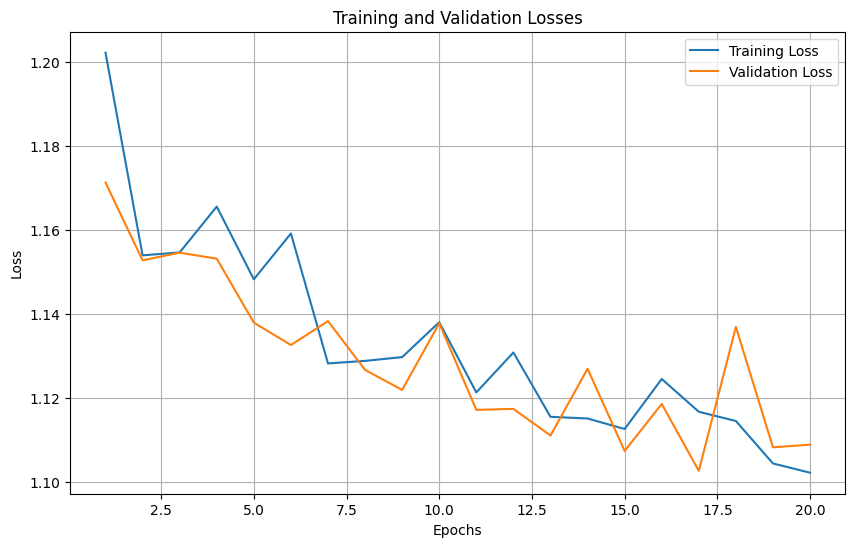

In [30]:
import matplotlib.pyplot as plt
epochs = range(1, len(training_losses) + 1)
plt.figure(figsize=(10, 6))
plt.plot(epochs, training_losses, label='Training Loss')
plt.plot(epochs, validation_losses, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Losses')
plt.legend()
plt.grid(True)
plt.show()

## Saving Model

In [22]:
!pwd

/home/sunil/Hate_Speech_Project/BERT_Model_HF


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


In [31]:
# Assuming `model_directory` is defined and points to where you want to save your model, tokenizer, and config
from transformers import AutoConfig
import os

# Define the directory where you want to save your model and tokenizer
model_directory = "/home/sunil/Hate_Speech_Project/BERT_Model_HF/bert_mutli_class_finetuned_model"

if not os.path.exists(model_directory):
    os.makedirs(model_directory)

# First, save your trained model and tokenizer
bert_model.save_pretrained(model_directory)
bert_tokenizer.save_pretrained(model_directory)

# Then, save the configuration
config = AutoConfig.from_pretrained("bert-base-uncased", num_labels=5) # Adjust as necessary
config.save_pretrained(model_directory)

print(f"Model, tokenizer, and configuration saved to {model_directory}")


Model, tokenizer, and configuration saved to /home/sunil/Hate_Speech_Project/BERT_Model_HF/bert_mutli_class_finetuned_model


## Loading the Saved Model

In [32]:
from transformers import AutoConfig, AutoModelForSequenceClassification
from transformers import AutoModelForSequenceClassification, AutoTokenizer

# Define the directory where your saved model and tokenizer are
model_directory = "/home/sunil/Hate_Speech_Project/BERT_Model_HF/bert_mutli_class_finetuned_model"

# Load the configuration and set the number of labels
config = AutoConfig.from_pretrained(model_directory, num_labels=5)

# Now, load the model with the updated configuration
model = AutoModelForSequenceClassification.from_pretrained(model_directory, config=config)

# Load the tokenizer as usual
tokenizer = AutoTokenizer.from_pretrained(model_directory)

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


## Evaluation of Validation set

In [33]:
%%time
import pandas as pd
import torch
from torch.nn.functional import softmax

# Assuming tokenizer and model are already defined and loaded
def prepare_input(text):
    inputs = tokenizer(text, return_tensors="pt", padding=True, truncation=True, max_length=512)
    return inputs

def predict(text):
    model.eval()  # Ensure the model is in evaluation mode
    inputs = prepare_input(text)
    with torch.no_grad():  # No need to track gradients for inference
        outputs = model(**inputs)
        predictions = softmax(outputs.logits, dim=-1)
    return predictions

# Function to predict and store results in a new CSV
def predict_and_store(csv_file_path):
    # Load the CSV file
    df = pd.read_csv(csv_file_path)
    
    # Ensure there's a column for predicted labels
    df['Predicted_Label'] = None
    
    # Iterate over each row in the DataFrame and make predictions
    for index, row in df.iterrows():
        text = row['Text']
        predictions = predict(text)
        predicted_class_index = predictions.argmax(dim=1).item()
        # Store the predicted class index in the DataFrame
        df.at[index, 'Predicted_Label'] = predicted_class_index
    
    # Define the name for the new CSV file that will contain the predictions
    predicted_csv_file_path = csv_file_path.replace('.csv', '_with_predictions.csv')
    
    # Save the modified DataFrame to the new CSV file
    df.to_csv(predicted_csv_file_path, index=False)
    
    # Log the creation of the new file with predictions
    print(f"Predictions stored in new file: {predicted_csv_file_path}")

# Example usage with your specific CSV file
csv_file_path = 'HSP_Val_Data_with_Encoded_Label_Multi_3.0.csv'
predict_and_store(csv_file_path)

Predictions stored in new file: HSP_Val_Data_with_Encoded_Label_Multi_3.0_with_predictions.csv
CPU times: user 8h 44min 33s, sys: 1min 55s, total: 8h 46min 29s
Wall time: 12min 32s


In [34]:
df = pd.read_csv("HSP_Val_Data_with_Encoded_Label_Multi_3.0_with_predictions.csv")
df.head()

,id,Text,Label_Id,Label,Label_Rev,Predicted_Label
0,3370,Zakhme dill dikhaye gey\nHaal e gham sunaye ge...,3,Neutral,2,1
1,4731,Always reassuring to know that as an ace perso...,3,Neutral,2,2
2,3283,"happy birthday to Rin Natsume, she’s a trans l...",1,Very_Positive,0,1
3,4991,William Gay in at free safety with the first-t...,3,Neutral,2,2
4,2146,seeing people say that being bi isn't real/doe...,3,Neutral,2,1


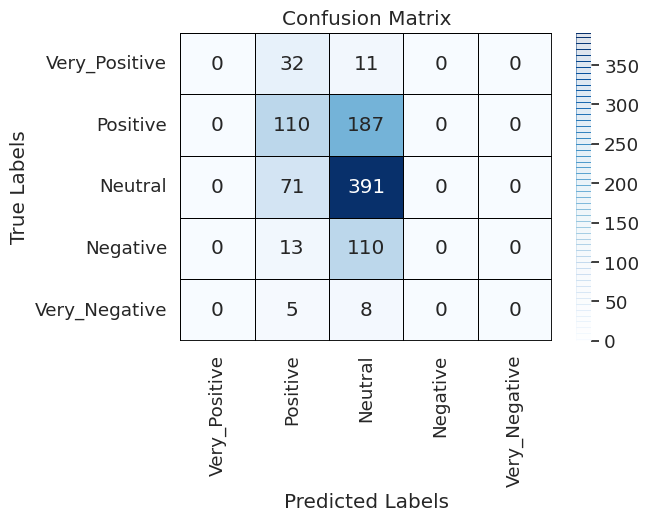

In [35]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score, classification_report

# Load the CSV file containing text data
df = pd.read_csv("HSP_Val_Data_with_Encoded_Label_Multi_3.0_with_predictions.csv")

label_mapping = {0: "Very_Positive", 1: "Positive", 2: "Neutral", 3: "Negative", 4: "Very_Negative"}

# Generate the confusion matrix
confusion = confusion_matrix(df["Label_Rev"], df["Predicted_Label"])

# Create a heatmap of the confusion matrix with class labels
plt.figure(figsize=(6, 4))
sns.set(font_scale=1.2)
ax = sns.heatmap(confusion, annot=True, fmt="d", cmap="Blues", xticklabels=label_mapping.values(), yticklabels=label_mapping.values(),
                 linewidths=.5, linecolor='black', cbar_kws={'drawedges': True})  # Add cbar_kws parameter

# Add explicit border lines
ax.add_artist(plt.Line2D([0, len(label_mapping)], [len(label_mapping), len(label_mapping)], color='black', linewidth=2))
ax.add_artist(plt.Line2D([len(label_mapping), len(label_mapping)], [0, len(label_mapping)], color='black', linewidth=2))

plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()

In [36]:
# Generate the classification report
classification_rep = classification_report(df["Label_Rev"], df["Predicted_Label"], target_names=list(label_mapping.values()))
print("Classification Report:\n", classification_rep)

Classification Report:
                precision    recall  f1-score   support

Very_Positive       0.00      0.00      0.00        43
     Positive       0.48      0.37      0.42       297
      Neutral       0.55      0.85      0.67       462
     Negative       0.00      0.00      0.00       123
Very_Negative       0.00      0.00      0.00        13

     accuracy                           0.53       938
    macro avg       0.21      0.24      0.22       938
 weighted avg       0.42      0.53      0.46       938



/home/sunil/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/sunil/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/sunil/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


## Evaluation of Test set

In [37]:
import pandas as pd
import torch
from torch.nn.functional import softmax

# Assuming tokenizer and model are already defined and loaded

def prepare_input(text):
    inputs = tokenizer(text, return_tensors="pt", padding=True, truncation=True, max_length=512)
    return inputs

def predict(text):
    model.eval()  # Ensure the model is in evaluation mode
    inputs = prepare_input(text)
    with torch.no_grad():  # No need to track gradients for inference
        outputs = model(**inputs)
        predictions = softmax(outputs.logits, dim=-1)
    return predictions

# Function to predict and store results in a new CSV
def predict_and_store(csv_file_path):
    # Load the CSV file
    df = pd.read_csv(csv_file_path)
    
    # Ensure there's a column for predicted labels
    df['Predicted_Label'] = None
    
    # Iterate over each row in the DataFrame and make predictions
    for index, row in df.iterrows():
        text = row['Text']
        predictions = predict(text)
        predicted_class_index = predictions.argmax(dim=1).item()
        # Store the predicted class index in the DataFrame
        df.at[index, 'Predicted_Label'] = predicted_class_index
    
    # Define the name for the new CSV file that will contain the predictions
    predicted_csv_file_path = csv_file_path.replace('.csv', '_with_predictions.csv')
    
    # Save the modified DataFrame to the new CSV file
    df.to_csv(predicted_csv_file_path, index=False)
    
    # Log the creation of the new file with predictions
    print(f"Predictions stored in new file: {predicted_csv_file_path}")

# Example usage with your specific CSV file
csv_file_path = 'HSP_Test_Data_with_Encoded_Label_Multi_3.0.csv'
predict_and_store(csv_file_path)

Predictions stored in new file: HSP_Test_Data_with_Encoded_Label_Multi_3.0_with_predictions.csv


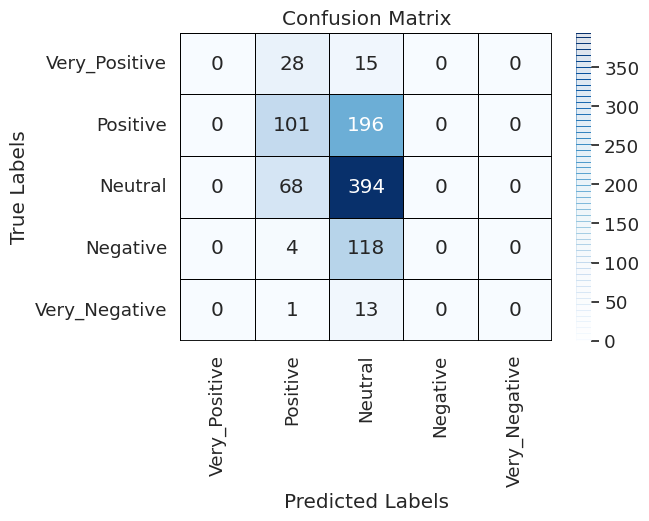

In [38]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score, classification_report

# Load the CSV file containing text data
df = pd.read_csv("HSP_Test_Data_with_Encoded_Label_Multi_3.0_with_predictions.csv")

label_mapping = {0: "Very_Positive", 1: "Positive", 2: "Neutral", 3: "Negative", 4: "Very_Negative"}

# Generate the confusion matrix
confusion = confusion_matrix(df["Label_Rev"], df["Predicted_Label"])

# Create a heatmap of the confusion matrix with class labels
plt.figure(figsize=(6, 4))
sns.set(font_scale=1.2)
ax = sns.heatmap(confusion, annot=True, fmt="d", cmap="Blues", xticklabels=label_mapping.values(), yticklabels=label_mapping.values(),
                 linewidths=.5, linecolor='black', cbar_kws={'drawedges': True})  # Add cbar_kws parameter

# Add explicit border lines
ax.add_artist(plt.Line2D([0, len(label_mapping)], [len(label_mapping), len(label_mapping)], color='black', linewidth=2))
ax.add_artist(plt.Line2D([len(label_mapping), len(label_mapping)], [0, len(label_mapping)], color='black', linewidth=2))

plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()

In [39]:
# Generate the classification report
classification_rep = classification_report(df["Label_Rev"], df["Predicted_Label"], target_names=list(label_mapping.values()))
print("Classification Report:\n", classification_rep)

Classification Report:
                precision    recall  f1-score   support

Very_Positive       0.00      0.00      0.00        43
     Positive       0.50      0.34      0.40       297
      Neutral       0.54      0.85      0.66       462
     Negative       0.00      0.00      0.00       122
Very_Negative       0.00      0.00      0.00        14

     accuracy                           0.53       938
    macro avg       0.21      0.24      0.21       938
 weighted avg       0.42      0.53      0.45       938



/home/sunil/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/sunil/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/sunil/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


### General Inferencing

In [40]:
import torch
from torch.nn.functional import softmax

def prepare_input(text):
    inputs = tokenizer(text, return_tensors="pt", padding=True, truncation=True, max_length=512)
    return inputs

def predict(text):
    model.eval()  # Ensure the model is in evaluation mode
    inputs = prepare_input(text)
    with torch.no_grad():  # No need to track gradients for inference
        outputs = model(**inputs)
        predictions = softmax(outputs.logits, dim=-1)
    return predictions

# Example usage
text = "India is My Country"
predictions = predict(text)
predicted_class_index = predictions.argmax(dim=1).item()
print(f"Predicted class index: {predicted_class_index}")

Predicted class index: 2


In [41]:
import torch
from torch.nn.functional import softmax

def prepare_input(text):
    inputs = tokenizer(text, return_tensors="pt", padding=True, truncation=True, max_length=512)
    return inputs

def predict(text):
    model.eval()  # Ensure the model is in evaluation mode
    inputs = prepare_input(text)
    with torch.no_grad():  # No need to track gradients for inference
        outputs = model(**inputs)
        predictions = softmax(outputs.logits, dim=-1)
    return predictions

# Example usage
text = "I hate you, You are worst gay."
predictions = predict(text)
predicted_class_index = predictions.argmax(dim=1).item()
print(f"Predicted class index: {predicted_class_index}")

Predicted class index: 2


In [42]:
import torch
from torch.nn.functional import softmax

def prepare_input(text):
    inputs = tokenizer(text, return_tensors="pt", padding=True, truncation=True, max_length=512)
    return inputs

def predict(text):
    model.eval()  # Ensure the model is in evaluation mode
    inputs = prepare_input(text)
    with torch.no_grad():  # No need to track gradients for inference
        outputs = model(**inputs)
        predictions = softmax(outputs.logits, dim=-1)
    return predictions

# Example usage
text = "LGBTQ+ people are also human, Give respect to save humanity."
predictions = predict(text)
predicted_class_index = predictions.argmax(dim=1).item()
print(f"Predicted class index: {predicted_class_index}")

Predicted class index: 1


In [43]:
!nvidia-smi

Sat May 25 02:19:22 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.171.04             Driver Version: 535.171.04   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  NVIDIA A100 80GB PCIe          Off | 00000000:21:00.0 Off |                    0 |
| N/A   38C    P0              70W / 300W |  62569MiB / 81920MiB |      0%      Default |
|                                         |                      |             Disabled |
+-----------------------------------------+----------------------+--

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
